<a href="https://colab.research.google.com/gist/JFMurphy/89dd5559a3dca7fb1154fb9a35a25fa5/0_handwriting_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct 30 09:36:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip uninstall mxnet mxnet-cu101
# !pip install 

Uninstalling mxnet-1.5.1.post0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/dmlc_tracker/*
    /usr/local/lib/python3.6/dist-packages/mxnet-1.5.1.post0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/mxnet/*
Proceed (y/n)? n


In [3]:
!pip install gluonnlp mxnet leven sacremoses mxboard
# !pip uninstall mxnet
# !pip install gluonnlp mxnet-cu100 leven sacremoses mxboard

# Mounting google drive folder

In [4]:
from google.colab import drive

drive.mount("./gdrive")

%cd "./gdrive/My Drive/Colab Notebooks/handwritten-text-recognition-for-apache-mxnet-master"
# !ls -l

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/handwritten-text-recognition-for-apache-mxnet-master


# End-To-End Handwriting Recognition

In [0]:
import difflib
import importlib
import math
import random
import string
import os

random.seed(123)

import cv2
import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch

import ocr.utils.denoiser_utils
import ocr.utils.beam_search

importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator

importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch


from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

In [0]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results. Randomly select 4 images for analysis.

In [0]:
#!less credentials.json

In [0]:
# test_ds = IAMDataset("form_original", train=False)

In [0]:
# test_ds[50][1]

In [0]:
img_folder = "original_samples/"

In [21]:
filelist=os.listdir('images/' + img_folder)
for file in filelist[:]: # filelist[:] makes a copy of filelist.
    if not(file.endswith(".png")):
        filelist.remove(file)
print(filelist)

['003.png', '009.png', '006.png', '010.png', '005.png', '001.png', '004.png', '002.png']


In [22]:
images = []

for file in filelist:
    images.append(cv2.imread(os.path.join('images/', img_folder, file), cv2.IMREAD_GRAYSCALE))

print(len(images))

8


In [23]:
images[0]

array([[234, 230, 231, ..., 250, 250, 250],
       [231, 230, 230, ..., 250, 250, 242],
       [230, 229, 234, ..., 242, 223, 227],
       ...,
       [174, 215, 227, ..., 223, 215, 208],
       [173, 217, 227, ..., 229, 227, 223],
       [174, 221, 231, ..., 227, 221, 234]], dtype=uint8)

In [0]:
random.seed(1)

In [0]:
# figs_to_plot = 4
# images = []

# n = 0
# for i in range(0, figs_to_plot):
#     n = int(random.random()*len(test_ds))
#     image, _ = test_ds[n]
#     images.append(image)

In [26]:
images

[array([[234, 230, 231, ..., 250, 250, 250],
        [231, 230, 230, ..., 250, 250, 242],
        [230, 229, 234, ..., 242, 223, 227],
        ...,
        [174, 215, 227, ..., 223, 215, 208],
        [173, 217, 227, ..., 229, 227, 223],
        [174, 221, 231, ..., 227, 221, 234]], dtype=uint8),
 array([[244, 244, 244, ..., 244, 217, 221],
        [244, 244, 244, ..., 244, 231, 217],
        [244, 244, 248, ..., 244, 231, 221],
        ...,
        [231, 231, 231, ..., 244, 231, 231],
        [231, 231, 244, ..., 248, 231, 221],
        [231, 231, 244, ..., 251, 244, 221]], dtype=uint8),
 array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [144, 248, 226, ..., 255, 255, 255],
        [164, 241, 207, ..., 255, 255, 255],
        [203, 247, 206, ..., 255, 255, 255]], dtype=uint8),
 array([[222, 222, 204, ..., 222, 228, 222],
        [222, 222, 204, ..., 204, 222, 228],
        [222, 22

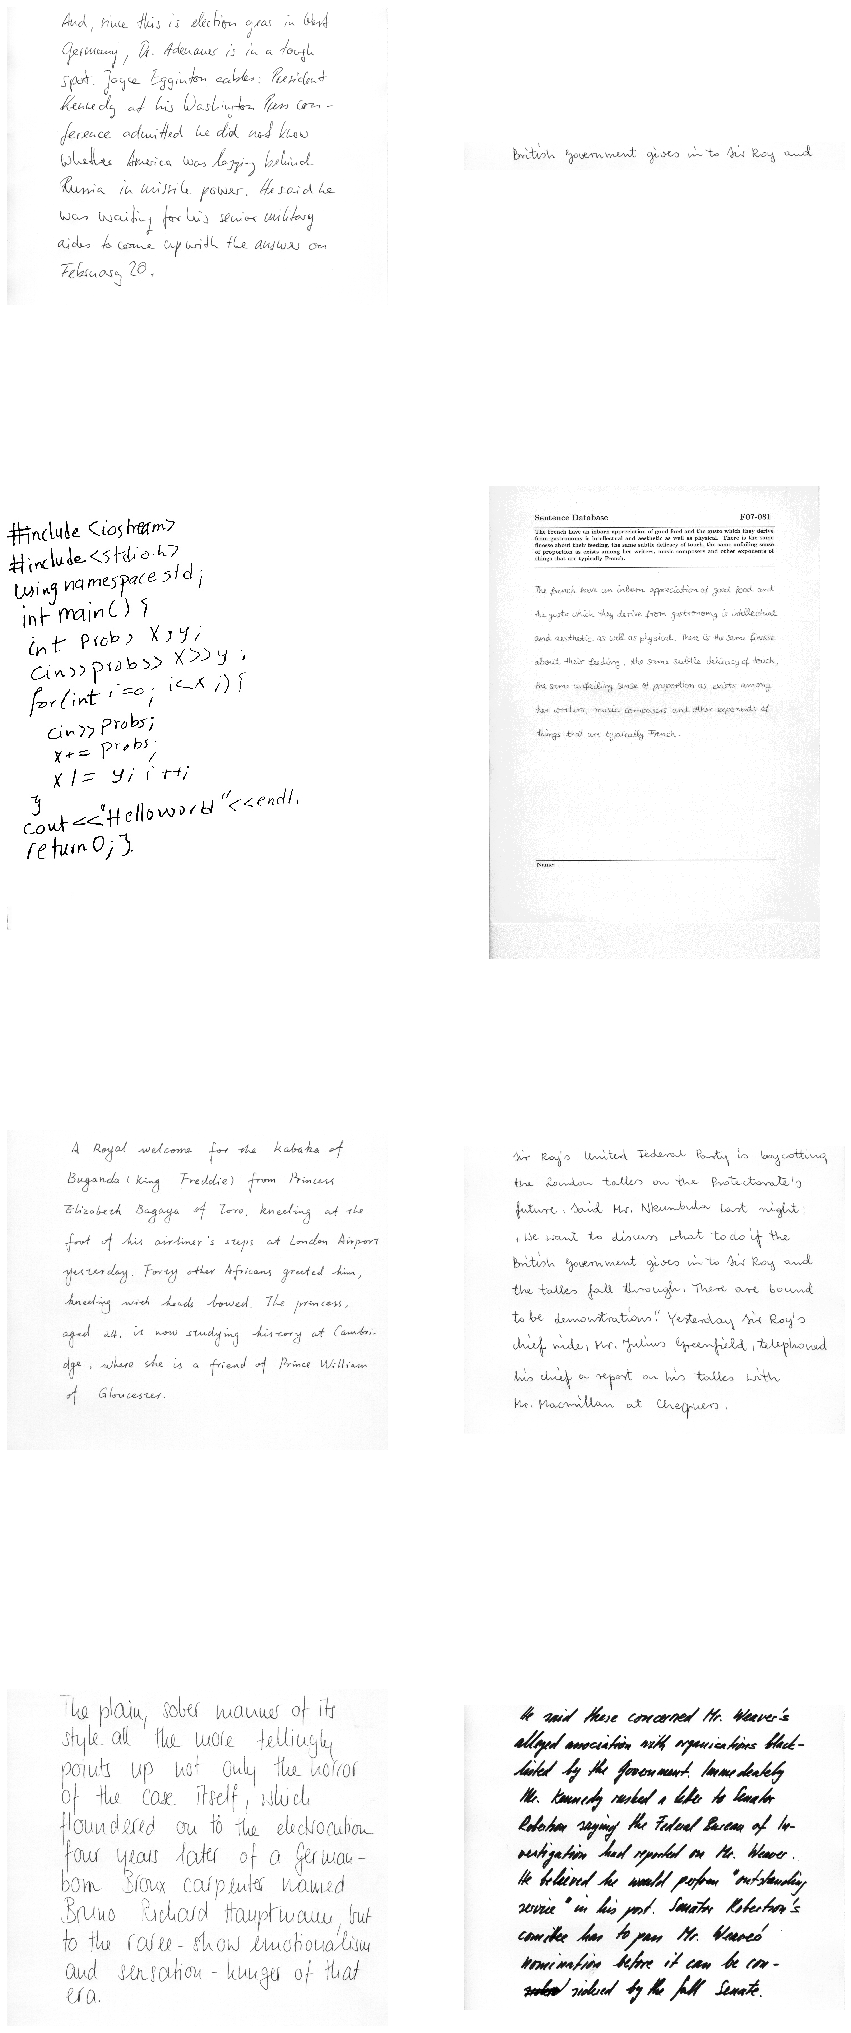

In [27]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

### Paragraph segmentation

Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [28]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

In [0]:
paragraph_segmentation_net.hybridize()

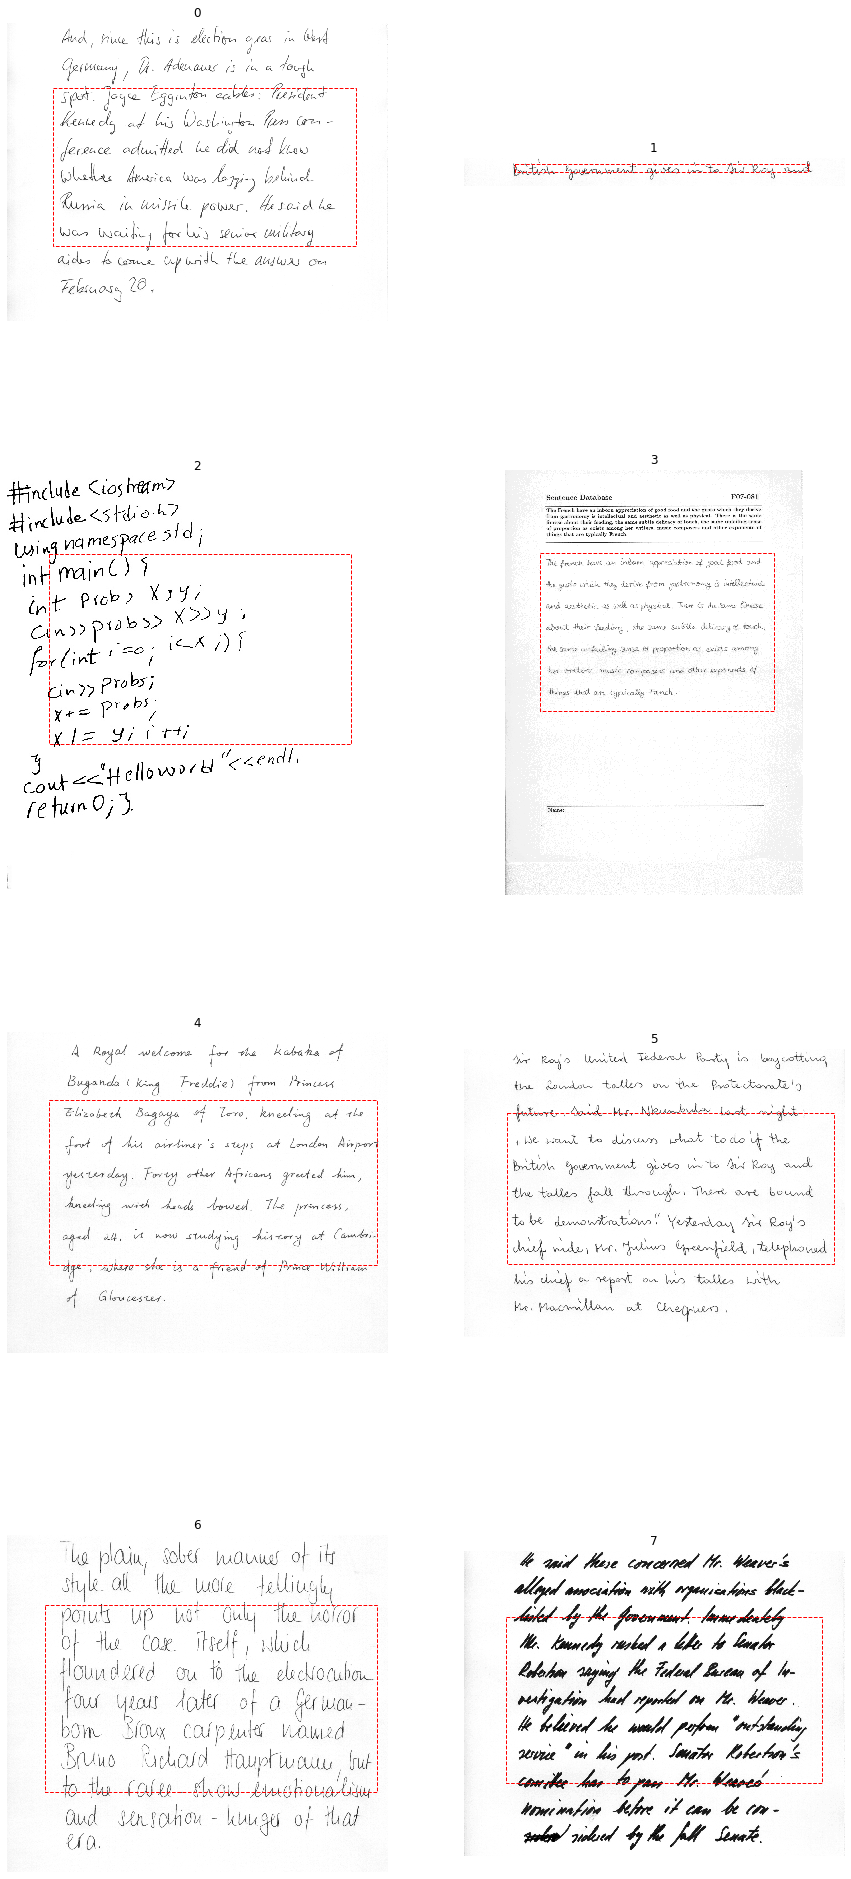

In [30]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

## Image Processing

Crop the handwriting component out of the original IAM form.



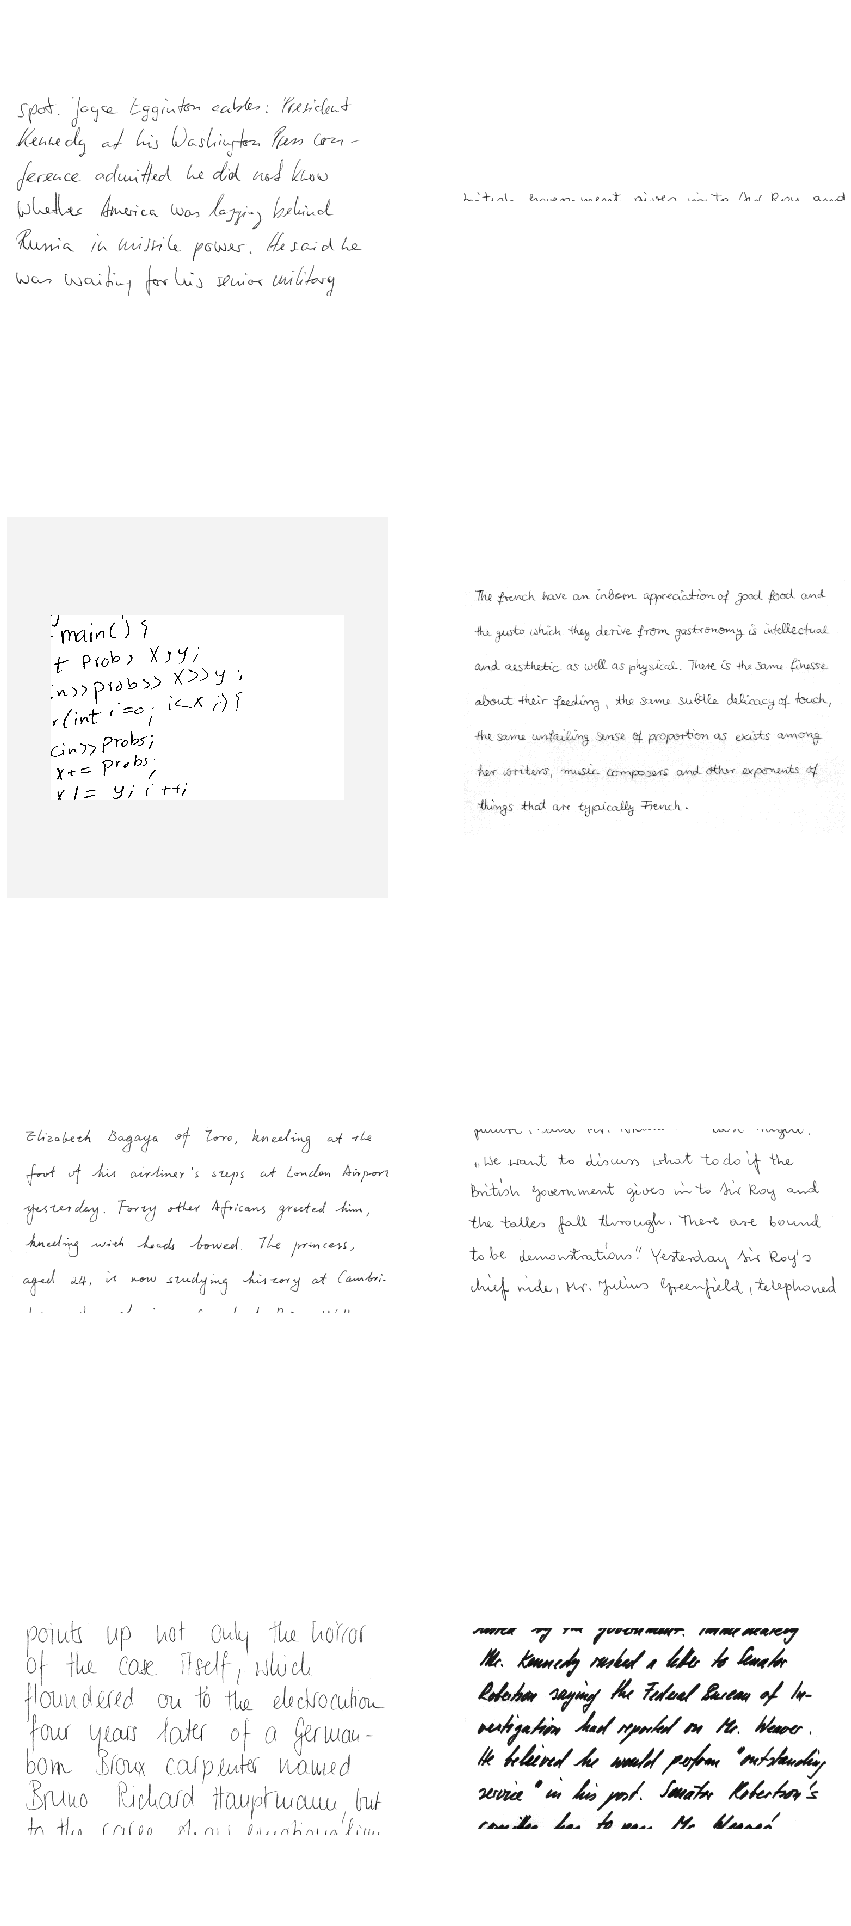

In [31]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## Line/word segmentation

Given a form with only handwritten text, predict a bounding box for each word. The model was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/word_segmentation.py

In [0]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

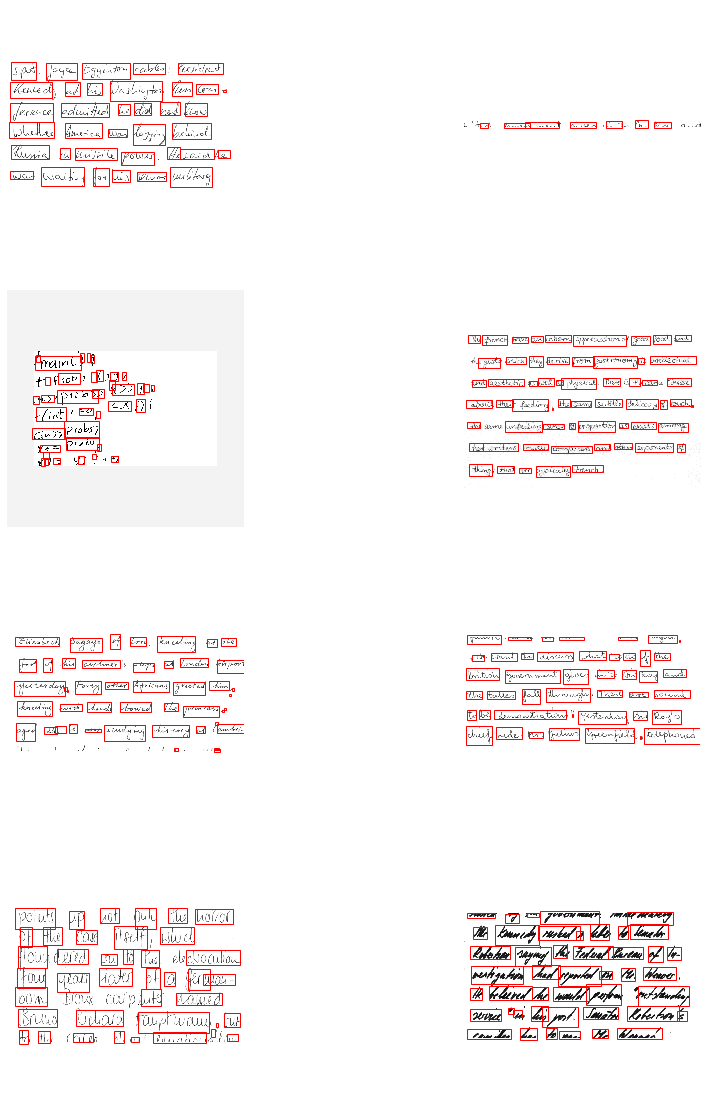

In [33]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

### Word to line image processing
Algorithm to sort then group all words within a line together.

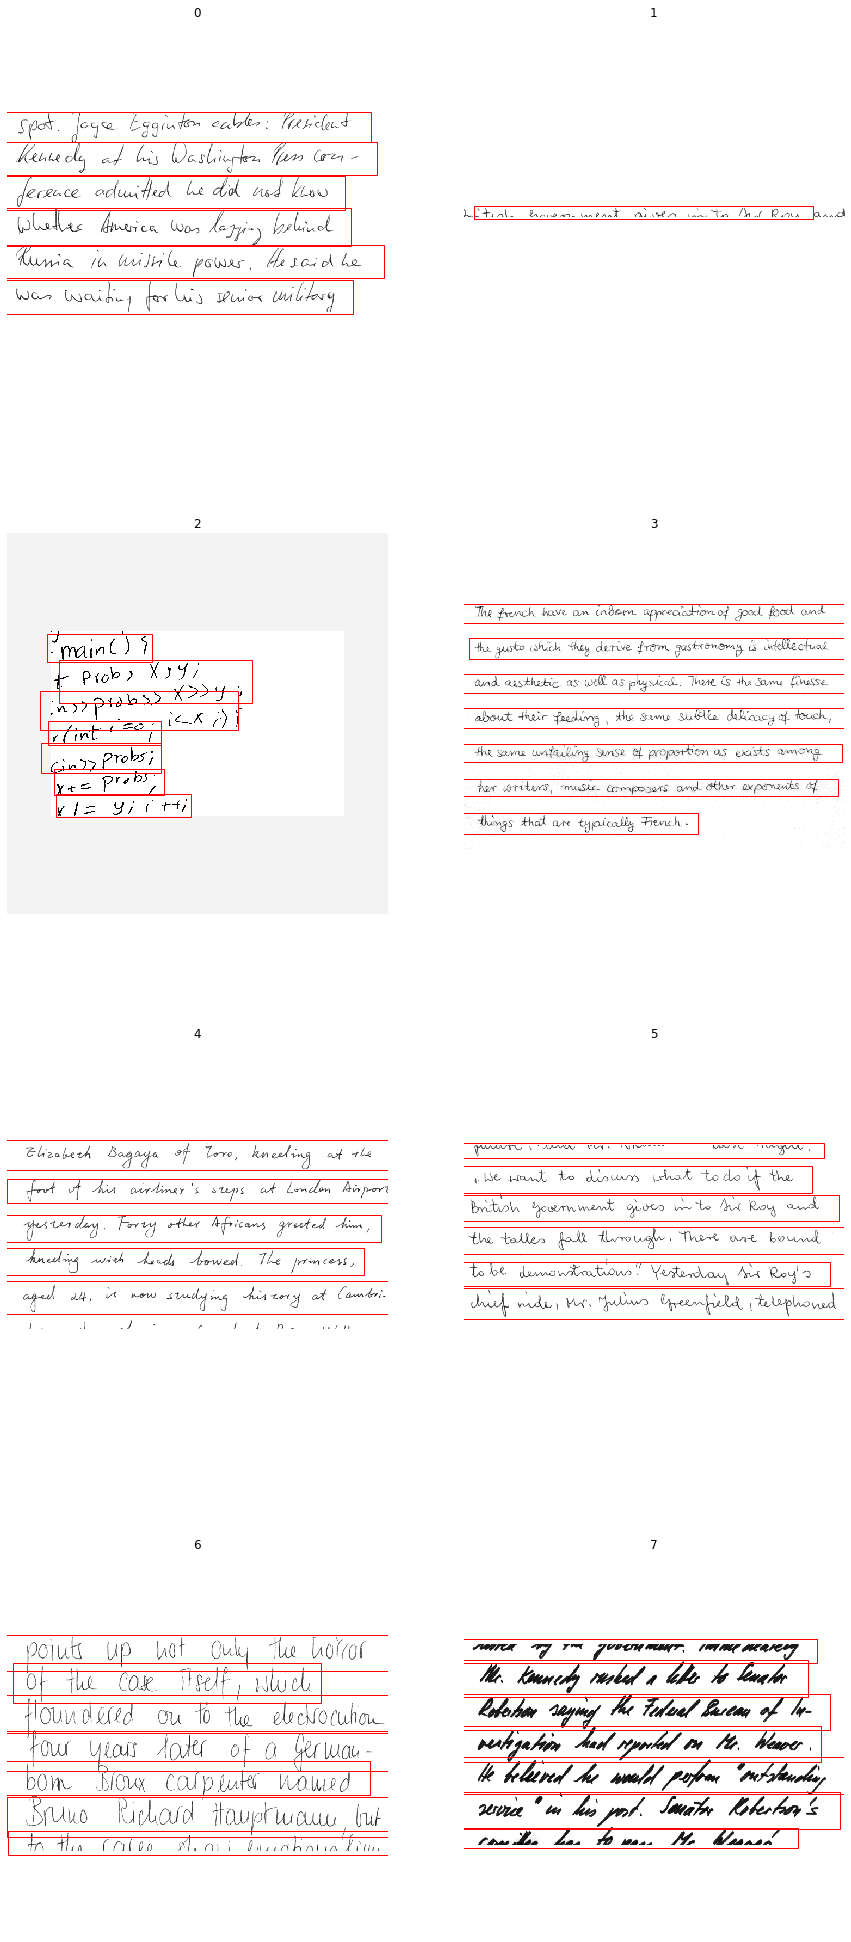

In [34]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

## Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [0]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [0]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

### Character Probalities to Text

In [0]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [0]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

## Denoising the text output

We use a seq2seq denoiser to translate noisy input to better output

In [0]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

In [0]:
denoiser.hybridize(static_alloc=True)

We use a language model in order to rank the propositions from the denoiser

In [41]:
ctx_nlp = mx.cpu()
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

Vocab file is not found. Downloading.


We use beam search to sample the output of the denoiser

In [0]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [0]:
generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx_nlp, moses_tokenizer, moses_detokenizer)

In [0]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)
    return output.strip()

In [45]:
sentence = "This sentnce has an eror"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
print(sentence)
print("Choice")
print(generator.generate_sequences(inputs, states, sentence))

This sentnce has an eror
Choice
T h i s   s e n t e n c e 


## Qualitative Result

- [AM] Arg Max CTC Decoding
- [BS] Beam Search CTC Decoding
- [D ] Adding Text Denoiser

[AM] spot. Yoyce tgginton cables: 'President
[D ] s p o t .   Y o y c e   b e g g i n g   o
[AM] Kennedy at his Washington Press con-
[D ] Kennedy at his Washington Press con-
[AM] ference admitted he did not know
[D ] F e r e n c e   a d m i t t e d
[AM] whether America was lagging behind
[D ] whether America was lagging behind
[AM] Russia in missile power. He said he
[D ] Russia in missile power. He said he
[AM] was waiting for his senior militory
[D ] w a s   w a i t i n g   f o r   h i s
[AM] it.Nl. Ganom-immbnit siiden iini to this Rses.
[D ] i t .   W i l l .   C a n o m - i m m u n i t
[AM] "maink) I
[D ] " m a i n )   I
[AM] " Proby  Psy:
[D ] " Proby  Psy:
[AM] inszprzb3" "k iss
[D ] i n s p i r a b l e
[AM] "lint" 20;
[D ] "lint" 20;
[AM] cinis Probs;
[D ] C i n i s   P
[AM] "It " probss;
[D ] " I t "   p r o
[AM] t t - isi i tti
[D ] t h a t   i t   -
[AM] The French have an inborn appreciation of good food and
[D ] The French have an inborn appreciation of good food and
[AM

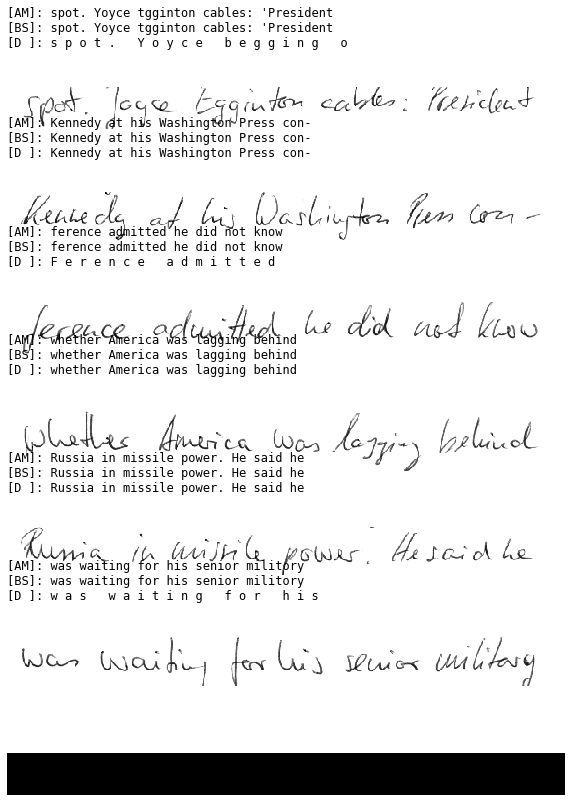

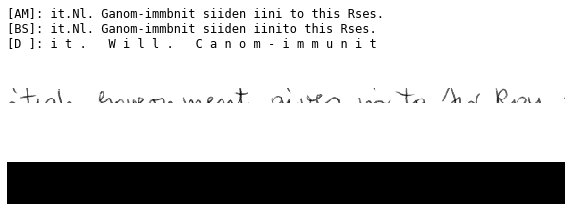

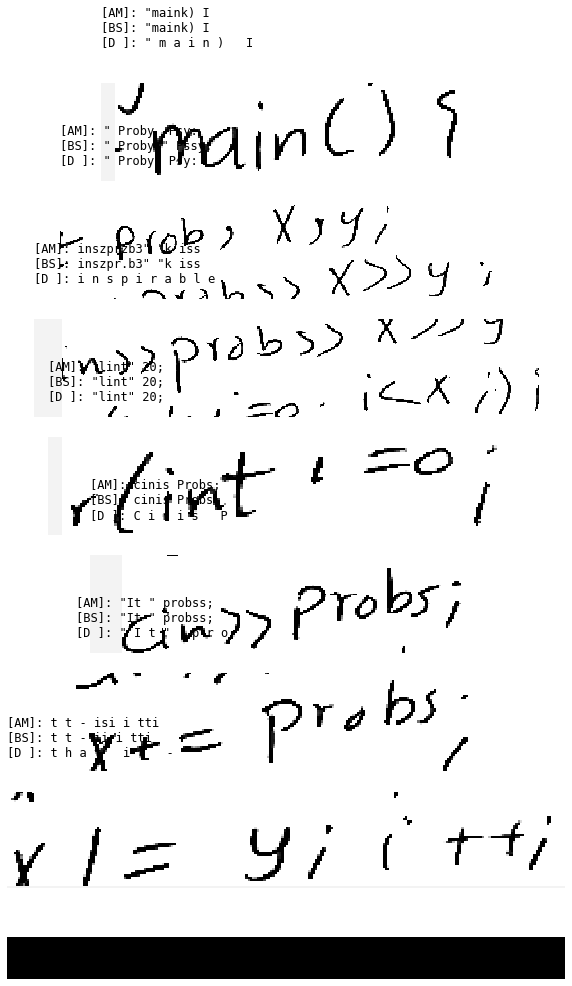

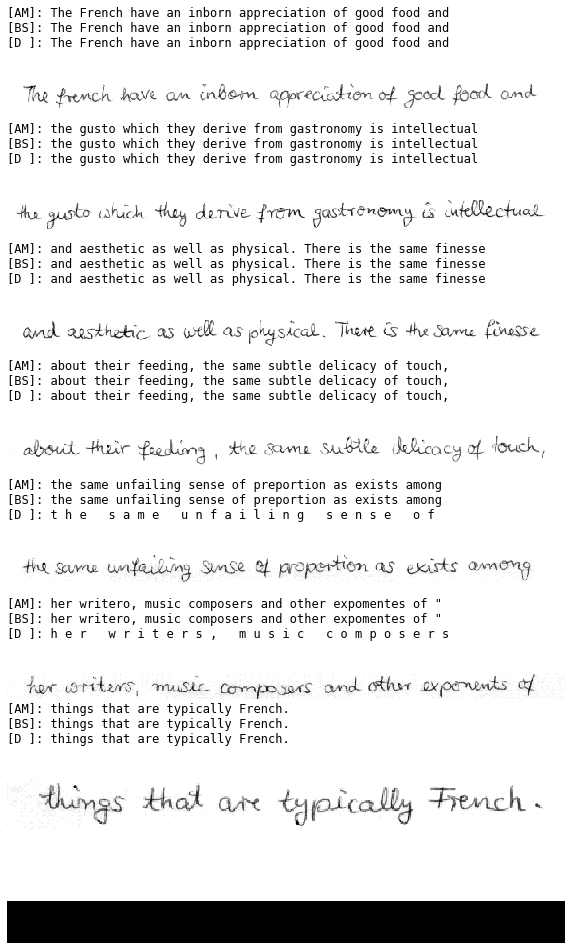

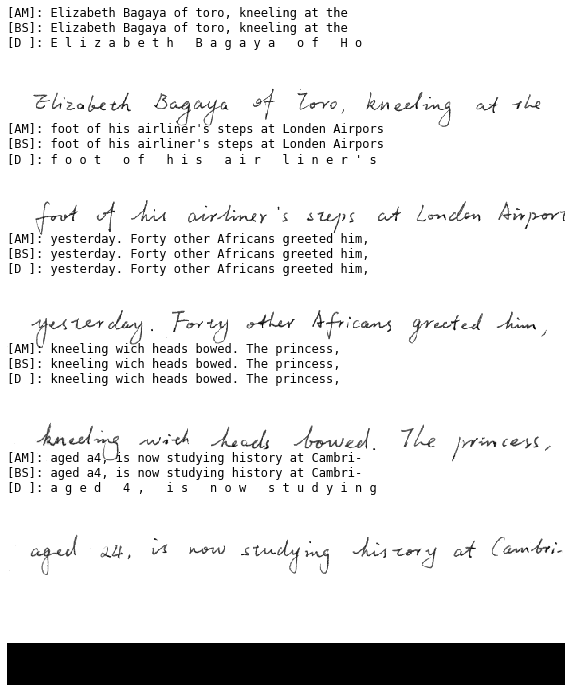

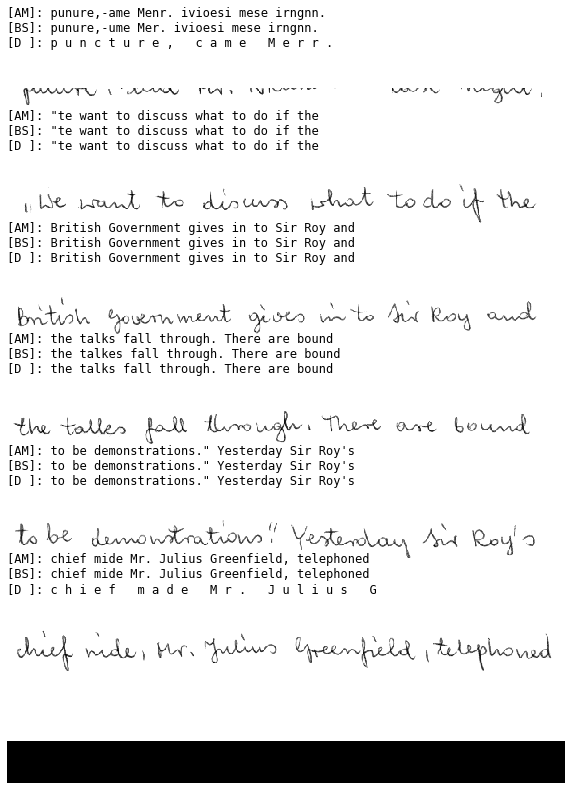

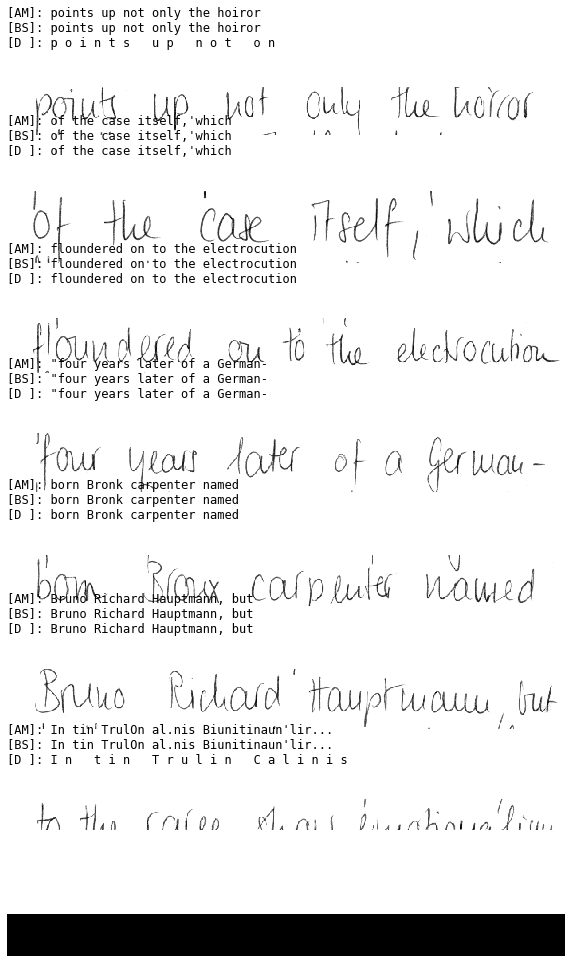

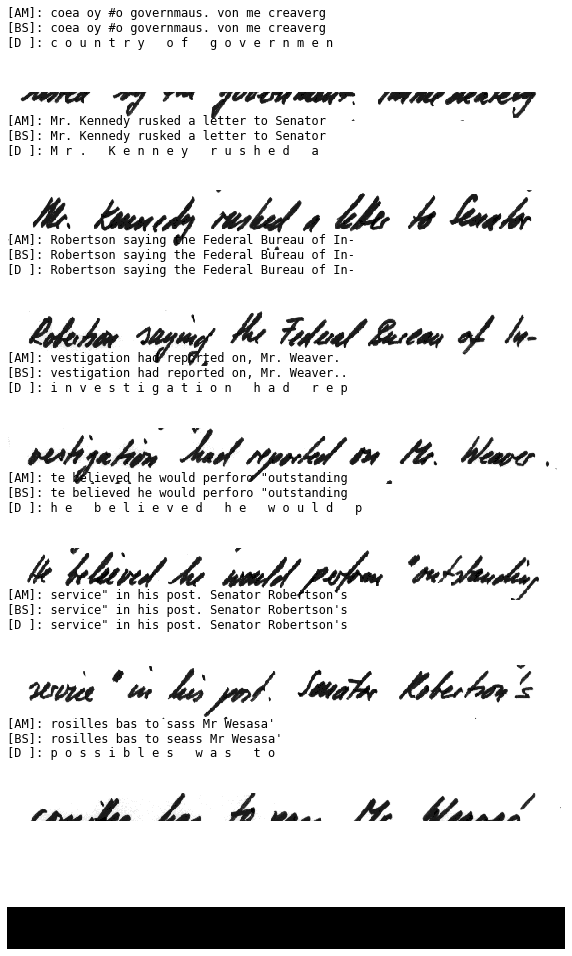

In [46]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[AM]",decoded_line_am)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[D ]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[AM]: {}\n[BS]: {}\n[D ]: {}\n\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# Quantitative Results
Iterative through the test data with the previous tests to obtain the total Character Error Rate (CER).

In [0]:
sclite = ScliteHelper('../SCTK/bin')

def get_qualitative_results_lines(denoise_func):
    sclite.clear()
    test_ds_line = IAMDataset("line", train=False)
    for i in tqdm(range(1, len(test_ds_line))):
        image, text = test_ds_line[i]
        line_image = exposure.adjust_gamma(image, 1)
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        decoded_text = denoise_func(character_probabilities)
        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        sclite.add_text([decoded_text], [actual_text])
    
    cer, er = sclite.get_cer()
    print("Mean CER = {}".format(cer))
    return cer

In [0]:
def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in tqdm(range(1, len(test_ds))):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=form_size)
        paragraph_bb = paragraph_segmentation_net(resized_image.as_in_context(ctx))
        paragraph_bb = paragraph_bb[0].asnumpy()
        paragraph_bb = expand_bounding_box(paragraph_bb, expand_bb_scale_x=0.01,
                                               expand_bb_scale_y=0.01)
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb, image_size=segmented_paragraph_size)
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)        
        line_bbs = sort_bbs_line_by_line(word_bb, y_overlap=0.4)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = exposure.adjust_gamma(line_image, 1)
            line_image = handwriting_recognition_transform(line_image, line_image_size)
            character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    cer, _ = sclite.get_cer()
    print("Mean CER = {}".format(cer))
    return cer

CER with pre-segmented lines

In [0]:
get_qualitative_results_lines(get_arg_max)

In [0]:
get_qualitative_results_lines(get_denoised)

CER full pipeline

In [0]:
get_qualitative_results(get_arg_max)

In [0]:
get_qualitative_results(get_beam_search)

In [0]:
cer_denoiser = get_qualitative_results(get_denoised)
cer_denoiser

#### ideas:
    - weighted levenshtein
    - re-trained the language model on GBW [~ didn't work too well]
    - only penalize non-existing words
    - Add single word training for denoiser
    - having 2 best edit distance rather than single one
    - split sentences based on punctuation
    - use CTC loss for ranking
    - meta model to learn to weight the scores from each thing